# NNDL Project - Riccardo De Vidi - 2152869

## B. Training

### 1. Packages and data import

Packages import

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import time as time

import matplotlib.pyplot as plt

import IPython.display as ip

Select the available device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Import generated data

In [ ]:
data = np.load("data.npz")
data = list(data.values())

Define the batch size and consider the biggest number of data elements that can be divided by it

In [ ]:
BATCH_SIZE = 128
data = data[0:(len(data)//BATCH_SIZE)*BATCH_SIZE]

print(f"{len(data)} data elements are considered")

39936 data elements are considered


### 2. Datasets and DataLoaders

In [ ]:
class MelodyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        prev_chord_bar = self.transform(self.data[idx][0]).float()
        prev_melody_bar = self.transform(self.data[idx][1]).float()
        melody_bar = self.transform(self.data[idx][3]).float()
        melody_bar = torch.cat((torch.zeros(1, 60, 16), melody_bar), dim=1)
        melody_bar = torch.cat((melody_bar, torch.zeros(1, 44, 16)), dim=1)
        return prev_chord_bar, prev_melody_bar, melody_bar

class ChordDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        prev_chord_bar = self.transform(self.data[idx][0]).float()
        prev_melody_bar = self.transform(self.data[idx][1]).float()
        chord_bar = self.transform(self.data[idx][2]).float()
        chord_bar = torch.cat((torch.zeros(1, 60, 16), chord_bar), dim=1)
        chord_bar = torch.cat((chord_bar, torch.zeros(1, 44, 16)), dim=1)
        return prev_melody_bar, prev_chord_bar, chord_bar

melody_dataset = MelodyDataset(data=data, transform=ToTensor())
chord_dataset = ChordDataset(data=data, transform=ToTensor())

### 3. Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):

        super().__init__()

        self.cond = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=(24, 2), stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Linear(2048, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(1024, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.noise_fc_net = nn.Sequential(
            nn.Linear(100, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=(1, 2), stride=2, bias=False), # 1x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(512, 256, (1, 2), stride=2, bias=False), # 1x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(256, 128, (1, 2), stride=2, bias=False), # 1x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 1, (128, 1), stride=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, noise, cond_1, cond_2):

        # Input noise
        n = self.noise_fc_net(noise).reshape((-1, 512, 1, 2))
        # Previous bars
        cn = self.cond(torch.cat([cond_1, cond_2], dim=1)).reshape((-1, 512, 1, 2))
        # Generator
        y = torch.cat([n, cn], dim=1)
        out = self.gen(y)

        return out

### 4. Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.prev_conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(24, 2), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=(1, 4), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        self.new_conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(128, 2), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=(1, 4), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(512*6, 1024, bias=False),
            nn.LeakyReLU(),
            nn.Linear(1024, 1024, bias=False),
            nn.LeakyReLU(),
            nn.Linear(1024, 1, bias=False)
        )

    def forward(self, prev, new):

        # Previous bar
        p = self.prev_conv(prev)
        # New or generated bar
        n = self.new_conv(new)
        # Fully connected network
        f = torch.cat([p, n], dim=1)
        out = self.fc(f)

        return out

### 5. Weights

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(0.02))
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(0.02))
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, np.sqrt(0.02))
        nn.init.constant_(m.bias.data, 0.0)

### 6. Losses

In [ ]:
cross_entropy = nn.BCEWithLogitsLoss()

def discriminator_loss(real_output, fake_output, device):
    real_loss = cross_entropy(real_output, torch.ones_like(real_output, device=device))
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))
    return gen_loss

### 7. Train functions

In [ ]:
def train_step(
    bars,
    generator,
    discriminator,
    batch_size,
    noise_dim,
    device,
    gen_opt,
    dis_opt,
    epoch
):

    generator.eval()
    discriminator.train()

    # Discriminator
    noise = torch.rand([batch_size, noise_dim], device=device)
    real_output = discriminator(bars[1], bars[2])
    fake_output = discriminator(bars[1], generator(noise, bars[1], bars[0]).detach())
    disc_loss = discriminator_loss(real_output, fake_output, device)
    dis_opt.zero_grad()
    disc_loss.backward()
    dis_opt.step()

    generator.train()
    discriminator.eval()

    # Generator
    noise = torch.rand([batch_size, noise_dim], device=device)
    generated_bars = generator(noise, bars[1], bars[0])
    fake_output = discriminator(bars[1], generated_bars)
    gen_loss = generator_loss(fake_output)
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    return gen_loss, disc_loss

In [ ]:
def train(
    dataloader,
    epochs,
    generator,
    discriminator,
    batch_size,
    noise_dim,
    device,
    gen_opt,
    dis_opt,
):

  gloss = []
  dloss = []

  for epoch in range(epochs):

    start = time.time()

    gen_losses = []
    disc_losses = []

    for bars in dataloader:

        bars = (bars[0].to(device), bars[1].to(device), bars[2].to(device))

        gen_loss, disc_loss = train_step(
            bars,
            generator,
            discriminator,
            batch_size,
            noise_dim,
            device,
            gen_opt,
            dis_opt,
            epoch
        )

        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())

    gloss.append(np.mean(gen_losses))
    dloss.append(np.mean(disc_losses))

    ip.clear_output(wait=True)

    generator.eval()

    noise = torch.rand([16, noise_dim], device=device)

    generated = generator(noise, bars[1][0:16], bars[0][0:16]).detach().cpu()*255

    grid = make_grid(generated, 16).numpy().squeeze().transpose(1, 2, 0)

    plt.imshow(grid.astype(np.uint8) , cmap='binary')
    plt.axis('off')
    plt.show()

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('Generator loss is {}'.format(gloss[-1]))
    print('Discriminator loss is {}'.format(dloss[-1]))

  return gloss, dloss

### 8. Training

Hyperparameters

In [ ]:
EPOCHS = 300
NOISE_DIM = 100

Melody DCGAN training

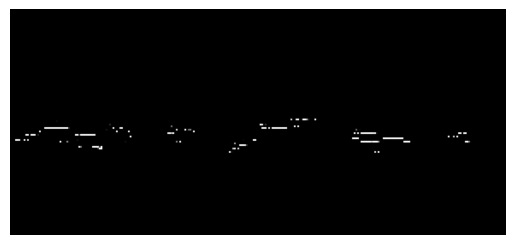

Time for epoch 300 is 14.036477088928223 sec
Generator loss is 3.4066076278686523
Discriminator loss is 0.6700222492218018


In [ ]:
generator = Generator()
generator.apply(weights_init)
discriminator = Discriminator()
discriminator.apply(weights_init)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

dataloader = DataLoader(melody_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

generator.to(device)
discriminator.to(device)

gloss, dloss = train(
    dataloader,
    EPOCHS,
    generator,
    discriminator,
    BATCH_SIZE,
    NOISE_DIM,
    device,
    gen_opt,
    dis_opt,
)

torch.save(generator.state_dict(), 'melody_generator.pth')

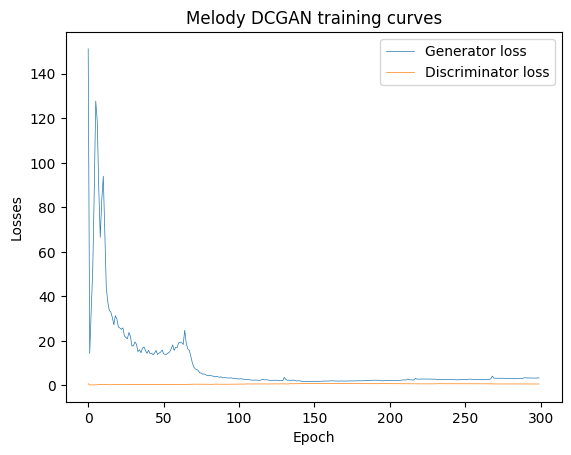

In [ ]:
plt.plot(gloss, label="Generator loss", linewidth=0.5)
plt.plot(dloss, label="Discriminator loss", linewidth=0.5)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Melody DCGAN training curves')
plt.show()

Chord DCGAN training

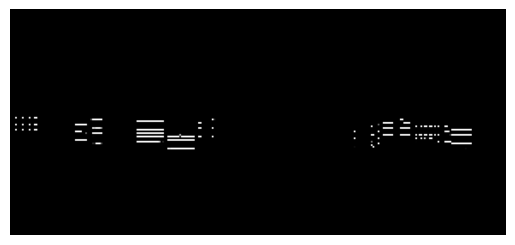

Time for epoch 300 is 13.89021897315979 sec
Generator loss is 2.241816759109497
Discriminator loss is 0.8084931969642639


In [ ]:
generator = Generator()
generator.apply(weights_init)
discriminator = Discriminator()
discriminator.apply(weights_init)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

dataloader = DataLoader(chord_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

generator.to(device)
discriminator.to(device)

gloss, dloss = train(
    dataloader,
    EPOCHS,
    generator,
    discriminator,
    BATCH_SIZE,
    NOISE_DIM,
    device,
    gen_opt,
    dis_opt,
)

torch.save(generator.state_dict(), 'chord_generator.pth')

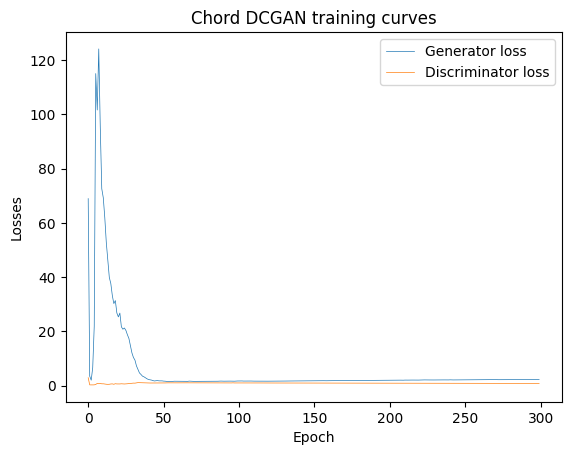

In [ ]:
plt.plot(gloss, label="Generator loss", linewidth=0.5)
plt.plot(dloss, label="Discriminator loss", linewidth=0.5)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Chord DCGAN training curves')
plt.show()